In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from numpy.linalg import pinv
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.linear_model import SGDRegressor, LinearRegression

In [74]:
data = pd.read_csv('viscosityData.csv', index_col=0)
data.head(3)

,DES,T/K,V/cP,MCI,Avg Molar,omega
0,DES2,293.15,0.0489,0.051962,87.66,1.7208
1,DES2,293.85,0.0479,0.050127,87.66,1.7208
2,DES2,294.65,0.0459,0.048136,87.66,1.7208


## Exploratory Data Analysis

In [75]:
data.describe()

,T/K,V/cP,MCI,Avg Molar,omega
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,308.201812,0.213665,0.207422,145.210250,4.611008
std,8.907018,0.297387,0.281433,40.474802,1.835703
min,293.050000,0.010900,0.009375,74.480000,1.607000
25%,300.675000,0.051400,0.052663,112.922500,3.300225
50%,308.200000,0.105500,0.104687,145.915000,4.388400
75%,315.725000,0.243500,0.239227,178.190000,5.775900
max,323.250000,2.776700,2.773863,236.270000,9.285700


In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1600 entries, 0 to 1599
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DES        1600 non-null   object 
 1   T/K        1600 non-null   float64
 2   V/cP       1600 non-null   float64
 3   MCI        1600 non-null   float64
 4   Avg Molar  1600 non-null   float64
 5    omega     1600 non-null   float64
dtypes: float64(5), object(1)
memory usage: 87.5+ KB


In [77]:
data.isna().sum()  

DES          0
T/K          0
V/cP         0
MCI          0
Avg Molar    0
 omega       0
dtype: int64

In [78]:
data.duplicated().sum()

0

In [79]:
data.nunique()

DES            40
T/K            60
V/cP          793
MCI          1600
Avg Molar      40
 omega         40
dtype: int64

In [84]:
data.drop(data.columns[0],inplace=True,axis=1)
data.head(3)


,T/K,V/cP,MCI,Avg Molar,omega
0,293.15,0.0489,0.051962,87.66,1.7208
1,293.85,0.0479,0.050127,87.66,1.7208
2,294.65,0.0459,0.048136,87.66,1.7208


In [85]:
viscosity = data.iloc[:,1]

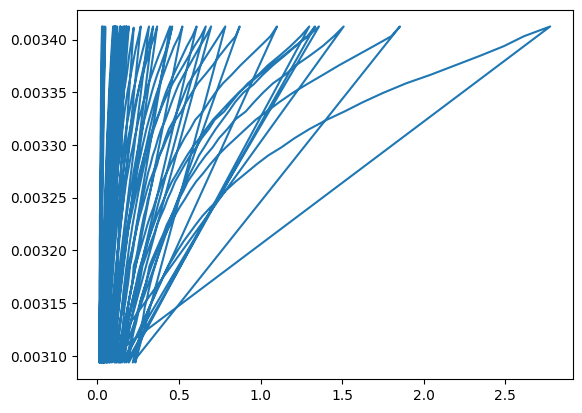

In [86]:
from matplotlib import pyplot as plt
    
# Relation with Temperature:
temperature = np.array(list(data.iloc[:,0]))
temp_inv = 1 / temperature
# Temperature inverse relation with viscosity
plt.plot(viscosity,temp_inv)

In [120]:
data['inv_Temp'] = temp_inv

In [121]:
# X = data[['inv_Temp','MCI','Avg Molar',' omega']]
# y = data['V/cP']
# print(X.shape, y.shape)

X = data[['inv_Temp','MCI','Avg Molar',' omega']]
y = data['V/cP']
print(X.shape, y.shape)

(1600, 4) (1600,)


## Model Training

In [89]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

In [101]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [117]:
num_feature = X.select_dtypes(exclude="object").columns
inverstionCol = ["T/K"]

def outlierRemoval(X):
    Q1 = np.percentile(X, 25, axis=0)
    Q3 = np.percentile(X, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(X, lower_bound, upper_bound)

def inversionTemp(X):
    return 1/X


numeric_transformer = StandardScaler()
numeric_inputer = SimpleImputer(strategy="median")
clamping_transformer = FunctionTransformer(outlierRemoval, validate=False)

preprocessor = ColumnTransformer(
    [
    ("SimpleImputer",numeric_transformer,num_feature),   
    ("StandardScaler",numeric_transformer,num_feature),
    ("outlierRemoval",clamping_transformer,num_feature),
    ]
)

In [118]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
print(pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('SimpleImputer',
                                                  StandardScaler(),
                                                  Index(['inv_Temp', 'MCI', 'Avg Molar', ' omega'], dtype='object')),
                                                 ('StandardScaler',
                                                  StandardScaler(),
                                                  Index(['inv_Temp', 'MCI', 'Avg Molar', ' omega'], dtype='object')),
                                                 ('outlierRemoval',
                                                  FunctionTransformer(func=<function outlierRemoval at 0x000002C8C5775440>),
                                                  Index(['inv_Temp', 'MCI', 'Avg Molar', ' omega'], dtype='object'))]))])


In [119]:
transformed_X = pipeline.fit_transform(X)

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.2, random_state=42, shuffle=True)
y_test = y_test.to_numpy()

In [62]:
x = xgb.XGBRFRegressor(objective="reg:squarederror",
                         n_estimators=10,seed=123)
x.fit(X_train,y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=10, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

In [63]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
pred = x.predict(X_test)

rmse = np.sqrt(MSE(y_test,pred))
r2 = r2_score(y_test,pred)

print(rmse)
print(r2)

0.03998016855416573
0.9820192917736529


In [64]:
X_train=np.array(X_train)
y_train  = np.array(y_train)

In [67]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [68]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

c:\Users\atirs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\atirs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
c:\Users\atirs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\atirs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
c:\Users\atirs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Linear Regression
Model performance for Training set
- Root Mean Squared Error: 0.0174
- Mean Absolute Error: 0.0096
- R2 Score: 0.9966
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0172
- Mean Absolute Error: 0.0087
- R2 Score: 0.9967


Lasso
Model performance for Training set
- Root Mean Squared Error: 0.2916
- Mean Absolute Error: 0.1822
- R2 Score: 0.0357
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.2926
- Mean Absolute Error: 0.1776
- R2 Score: 0.0370


Ridge
Model performance for Training set
- Root Mean Squared Error: 0.0177
- Mean Absolute Error: 0.0095
- R2 Score: 0.9965
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0175
- Mean Absolute Error: 0.0089
- R2 Score: 0.9966


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 0.0216
- Mean Absolute Error: 0.0068
- R2 Score: 0.9947
-----------------------

c:\Users\atirs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 0.0067
- Mean Absolute Error: 0.0028
- R2 Score: 0.9995
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0229
- Mean Absolute Error: 0.0079
- R2 Score: 0.9941


XGBRegressor
Model performance for Training set
- Root Mean Squared Error: 0.0015
- Mean Absolute Error: 0.0010
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0399
- Mean Absolute Error: 0.0063
- R2 Score: 0.9821


CatBoosting Regressor
Model performance for Training set
- Root Mean Squared Error: 0.0030
- Mean Absolute Error: 0.0019
- R2 Score: 0.9999
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0190
- Mean Absolute Error: 0.0045
- R2 Score: 0.9959


AdaBoost Regressor
Model performance for Training set
- Root Mean Squared Error: 0.0342
- Mean Absolute Error: 0.0282
- R2 Score: 0.98

c:\Users\atirs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(


In [69]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
0,Linear Regression,0.996657
2,Ridge,0.996555
7,CatBoosting Regressor,0.995946
5,Random Forest Regressor,0.994092
4,Decision Tree,0.994082
3,K-Neighbors Regressor,0.988078
6,XGBRegressor,0.982112
8,AdaBoost Regressor,0.980948
1,Lasso,0.037007


In [71]:
lin_model = LinearRegression()
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 99.67


c:\Users\atirs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
